In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier 
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [8]:
customers = pd.read_csv('customers.csv')
customer_history = pd.read_csv('customer_history.csv')
reference_data = pd.read_csv('referance_data.csv')
reference_data_test = pd.read_csv('referance_data_test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [9]:
print(f"customers: {customers.shape}")
print(f"customer_history: {customer_history.shape}")
print(f"reference_data (train): {reference_data.shape}")
print(f"reference_data_test: {reference_data_test.shape}")

customers: (176293, 8)
customer_history: (5359609, 7)
reference_data (train): (133287, 3)
reference_data_test: (43006, 2)


In [10]:
print(f"\nChurn Dağılımı (reference_data):")
churn_counts = reference_data['churn'].value_counts()
print(churn_counts)
print(f"Churn Oranı: {reference_data['churn'].mean():.2%}")

# Sınıf dengesizliğini için pozitif sınıf ağırlığı
scale_pos_weight = churn_counts[0] / churn_counts[1]
print(f"Scale Positive Weight (0/1): {scale_pos_weight:.2f}")


Churn Dağılımı (reference_data):
churn
0    114417
1     18870
Name: count, dtype: int64
Churn Oranı: 14.16%
Scale Positive Weight (0/1): 6.06


In [11]:
# Tarihleri datetime'a çevirme
if "date" in customer_history.columns:
    customer_history["date"] = pd.to_datetime(customer_history["date"])
elif "month" in customer_history.columns:
    customer_history["date"] = pd.to_datetime(customer_history["month"])
else:
    date_col = [col for col in customer_history.columns if 'date' in col.lower() or 'month' in col.lower()]
    if date_col:
        customer_history['date'] = pd.to_datetime(customer_history[date_col[0]])

In [12]:
# Eksik işlem verilerini 0 ile doldur
fill_na_cols = ['mobile_eft_all_cnt', 'mobile_eft_all_amt', 'cc_transaction_all_amt', 'cc_transaction_all_cnt']
customer_history[fill_na_cols] = customer_history[fill_na_cols].fillna(0)

# Nümerik sütünlar (cust_id datetime hariç)
numeric_cols = customer_history.select_dtypes(include=[np.number]).columns.tolist()
if "cust_id" in numeric_cols:
    numeric_cols.remove("cust_id")
# Her müşteri için agregasyon
customer_features = customer_history.groupby("cust_id")[numeric_cols].agg([
    "mean", "std", "max", "min", "sum", "median"
]).reset_index()  
# Sütun isimlerini düzenle (multi-level'dan tek level'a)
customer_features.columns = ['cust_id'] + [f'{col}_{stat}' for col in numeric_cols for stat in ['mean', 'std', 'max', 'min', 'sum', 'median']]

In [13]:
# İlk 3 ay vs son 3 ay
if 'date' in customer_history.columns:
    customer_history_sorted = customer_history.sort_values(['cust_id', 'date'])
    
    # Son 3 ay ortalaması
    last_3_months = customer_history_sorted.groupby('cust_id').tail(3).groupby('cust_id')[numeric_cols].mean().reset_index()
    # Sütun isimlerini değiştir
    for col in numeric_cols:
        last_3_months.rename(columns={col: f'{col}_last3m_mean'}, inplace=True)
    
    # İlk 3 ay ortalaması
    first_3_months = customer_history_sorted.groupby('cust_id').head(3).groupby('cust_id')[numeric_cols].mean().reset_index()
    # Sütun isimlerini değiştir
    for col in numeric_cols:
        first_3_months.rename(columns={col: f'{col}_first3m_mean'}, inplace=True)
    
    # İki tabloyu birleştir
    trend_features = last_3_months.merge(first_3_months, on='cust_id', how='inner')
    
    # Trend hesapla (son - ilk)
    for col in numeric_cols:
        trend_features[f'{col}_trend'] = trend_features[f'{col}_last3m_mean'] - trend_features[f'{col}_first3m_mean']
    
    # Ana tabloya ekle
    customer_features = customer_features.merge(trend_features, on='cust_id', how='left')

In [14]:
activity_features = customer_history.groupby('cust_id').agg(
    transaction_count=('cust_id', 'count'),
    active_months=('date', 'nunique') if 'date' in customer_history.columns else ('cust_id', 'count')
).reset_index()

customer_features = customer_features.merge(activity_features, on='cust_id', how='left')

In [15]:
# Demografik bilgiler eklendi
customer_features = customer_features.merge(customers,on= "cust_id", how ="left")
print(f"\n Toplam {customer_features.shape[1]} özellik oluşturuldu.")
print(f"Veri boyutu: {customer_features.shape}")


 Toplam 55 özellik oluşturuldu.
Veri boyutu: (176293, 55)


In [16]:
# Veri ön işleme fonksiyonu (hem train hem test için)
def preprocess_data(df, is_train=True, churn_rate=None, encoders=None):
    # Eksik 'work_sector' değerlerini 'Missing' olarak işaretle
    if 'work_sector' in df.columns:
        df['work_sector'] = df['work_sector'].fillna('Missing')
    
    # One-Hot Encoding
    categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
    df = pd.get_dummies(df, columns=categorical_cols, dummy_na=False, drop_first=True)
    
    # NaN değerleri medyan ile doldur (işlem verileri zaten 0 ile dolduruldu)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        df[col] = df[col].fillna(df[col].median()) 
        
    return df

# Eğitim ve Test verilerini hazırlama
train_data = customer_features.merge(reference_data[['cust_id', 'churn']], on="cust_id", how="inner")
test_data = customer_features[customer_features['cust_id'].isin(reference_data_test['cust_id'])]

y = train_data["churn"]
churn_rate = y.mean()

# Ön işleme uygula
train_data_processed = preprocess_data(train_data.drop(columns=['churn']), is_train=True)
test_data_processed = preprocess_data(test_data)

print(f"Train verisi hazırlandı: {train_data_processed.shape}")
print(f"Test verisi hazırlandı: {test_data_processed.shape}")

Train verisi hazırlandı: (133287, 78)
Test verisi hazırlandı: (43006, 78)


In [17]:
# Eğitim ve test verilerini hizalama (One-Hot Encoding sonrası)
common_cols = list(set(train_data_processed.columns) & set(test_data_processed.columns))
common_cols.remove('cust_id')

X_train_full = train_data_processed[common_cols]
X_test_full = test_data_processed[common_cols]

print(f"Hizalanmış özellik sayısı: {X_train_full.shape[1]}")

Hizalanmış özellik sayısı: 77


In [19]:
# Modelleme: XGBoost kullanımı
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y, test_size=0.2, random_state=42, stratify=y)

# XGBClassifier kullanımı ve scale_pos_weight ile sınıf dengesizliğinin ele alınması
print("XGBoost Eğitimi Başlıyor...")
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=1000,  
    learning_rate=0.03, 
    max_depth=5, 
    subsample=0.7, 
    colsample_bytree=0.7, 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    verbose=0 
)

xgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              verbose=False)

# Tahminler
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

XGBoost Eğitimi Başlıyor...



 ROC AUC: 0.7127
 Gini Coefficient: 0.4254

 Recall@10%: 0.2149
 Lift@10%: 2.1496

 Ağırlıklı Skor: 0.8795
   (Gini: 40%, Recall@10%: 30%, Lift@10%: 30%)

 En Önemli 20 Özellik:
                                     feature  importance
13           active_product_category_nbr_min    0.169182
8           active_product_category_nbr_mean    0.079553
38   active_product_category_nbr_last3m_mean    0.052116
61        active_product_category_nbr_median    0.045265
0            active_product_category_nbr_max    0.044322
57  active_product_category_nbr_first3m_mean    0.031091
42            mobile_eft_all_cnt_last3m_mean    0.015734
4          active_product_category_nbr_trend    0.013887
1         cc_transaction_all_cnt_last3m_mean    0.012878
55                    mobile_eft_all_cnt_max    0.012325
67                    mobile_eft_all_cnt_sum    0.012141
45           active_product_category_nbr_sum    0.011231
35                   mobile_eft_all_cnt_mean    0.010984
23            mobile_ef

<Figure size 1000x800 with 0 Axes>

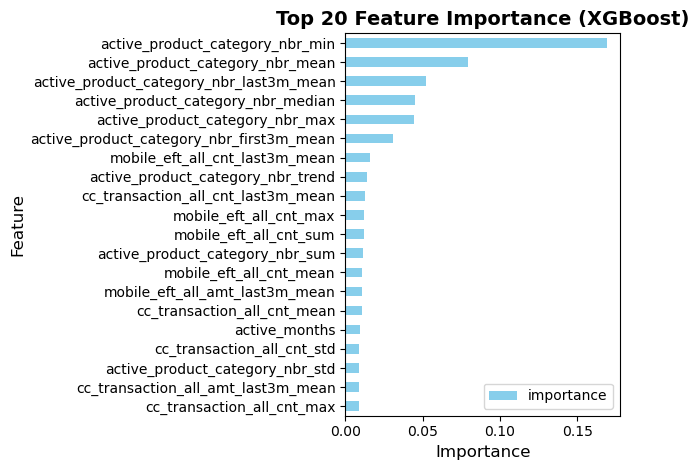

In [20]:
# 1. ROC AUC ve Gini
roc_auc = roc_auc_score(y_val, y_pred_proba)
gini = 2 * roc_auc - 1

print(f"\n ROC AUC: {roc_auc:.4f}")
print(f" Gini Coefficient: {gini:.4f}")

# 2. Recall@10% ve Lift@10%
def calculate_recall_at_k(y_true, y_pred_proba, k=0.1):
    """Top k% müşterideki recall hesapla"""
    n = len(y_true)
    n_top = int(n * k)
    
    # En yüksek skorlu müşterileri seç
    top_indices = np.argsort(y_pred_proba)[-n_top:]
    
    # Bu müşteriler içindeki gerçek churn sayısı
    # y_true'nun bir Pandas Serisi olduğundan emin ol
    if not isinstance(y_true, pd.Series): y_true = pd.Series(y_true)
    
    recall = y_true.iloc[top_indices].sum() / y_true.sum()
    return recall

def calculate_lift_at_k(y_true, y_pred_proba, k=0.1):
    """Top k% müşterideki lift hesapla"""
    n = len(y_true)
    n_top = int(n * k)
    
    # En yüksek skorlu müşterileri seç
    top_indices = np.argsort(y_pred_proba)[-n_top:]
    
    # y_true'nun bir Pandas Serisi olduğundan emin ol
    if not isinstance(y_true, pd.Series): y_true = pd.Series(y_true)
    
    # Top k%'deki churn oranı
    churn_rate_top_k = y_true.iloc[top_indices].mean()
    
    # Genel churn oranı
    overall_churn_rate = y_true.mean()
    
    # Lift = (Top k%'deki churn oranı) / (Genel churn oranı)
    lift = churn_rate_top_k / overall_churn_rate if overall_churn_rate > 0 else 0
    return lift

recall_10 = calculate_recall_at_k(y_val, y_pred_proba, k=0.1)
lift_10 = calculate_lift_at_k(y_val, y_pred_proba, k=0.1)

print(f"\n Recall@10%: {recall_10:.4f}")
print(f" Lift@10%: {lift_10:.4f}")

# Ağırlıklı skor (yarışma metriği)
weighted_score = (gini * 0.4) + (recall_10 * 0.3) + (lift_10 * 0.3)
print(f"\n Ağırlıklı Skor: {weighted_score:.4f}")
print(f"   (Gini: 40%, Recall@10%: 30%, Lift@10%: 30%)")

# Feature Importance
print("\n En Önemli 20 Özellik:")
feature_importance = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20))

plt.figure(figsize=(10, 8))
feature_importance.head(20).plot(x='feature', y='importance', kind='barh', color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Test verisi için cust_id'yi kaydet
test_cust_ids = test_data_processed['cust_id']

# Tahmin yap
print("\n Test verisi için tahminler yapılıyor...")
test_predictions = xgb_model.predict_proba(X_test_full)[:, 1]

# Tahminleri sample_submission formatına dönüştür
submission = pd.DataFrame({'cust_id': test_cust_ids, 'churn': test_predictions})
submission.to_csv('submission_optimized_xgb.csv', index=False)
print("Tahminler 'submission_optimized_xgb.csv' dosyasına kaydedildi.")


 Test verisi için tahminler yapılıyor...
Tahminler 'submission_optimized_xgb.csv' dosyasına kaydedildi.
